In [ ]:
import torch # memory errory everytime i run :)
from torch import nn
import torchvision
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
import requests
from pathlib import Path
data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

if image_path.is_dir():
    print("data already downloaded")
else:
    print("creating directory")
    image_path.mkdir()


data already downloaded


In [ ]:
with open(image_path/"images.zip",mode="wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(request.content)

In [ ]:
import zipfile
zep_ref = zipfile.ZipFile(image_path/"images.zip")
zep_ref.extractall(image_path)

### Becoming One with the data:

In [ ]:
train_dir = image_path/ "train"
test_dir = image_path/"test"

### Visualising the images:

In [ ]:
import random
from PIL import Image # PIL stands for Pillow library!
image_path_list = list(image_path.glob("*/*/*.jpg"))

In [ ]:
train_images=[] #list
image_train_labels=[]
image_train_path_list = list(image_path.glob("train/*/*.jpg"))
for i in image_train_path_list:
    image = Image.open(i)
    image_train_labels.append(i.parent.stem)
    train_images.append(image)

In [ ]:
test_images =[]
image_test_path_list = list(image_path.glob("test/*/*.jpg"))
image_test_labels =[]
for i in image_test_path_list:
    image = Image.open(i)
    test_images.append(image)
    image_class = i.parent.stem
    image_test_labels.append(image_class)

In [ ]:
from PIL import ImageOps

In [ ]:
# Padding all images:
import numpy as np
def PaddingImagesInList(image_list:list):
    padded_images=[]
    max_height = max(img.height for img in image_list)
    max_width = max(img.width for img in image_list)
    print(f"max_height: {max_height} and max_widht: {max_width}")
    train_np = []
    for img in image_list:
        padding = (0,0,max_width -img.width,max_height-img.height)
        padded_image = ImageOps.expand(img,padding,fill=0)
        padded_images.append(padded_image) # fill means black pixels are added
    return padded_images

In [ ]:
padded_train_images = PaddingImagesInList(train_images)
padded_test_images = PaddingImagesInList(test_images)

max_height: 512 and max_widht: 512
max_height: 512 and max_widht: 512


pizza


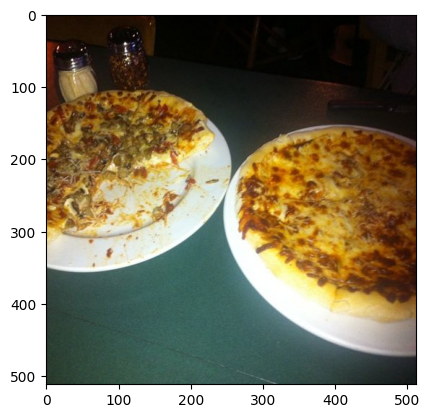

In [ ]:
plt.imshow(padded_train_images[0])
print(image_train_labels[0])

In [ ]:
train_images_array = np.stack([np.array(img) for img in padded_train_images])
test_images_array = np.stack([np.array(img) for img in padded_test_images])

In [ ]:
train_images_array.shape # 225 elements where elem is 512 widht 512 height 3 colour channel

(225, 512, 512, 3)

### Creating CNN Model:

In [ ]:
import torch.nn as nn

class FoodDetector(nn.Module):
    def __init__(self):
        super(FoodDetector,self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=100,kernel_size=(2,2),stride=1,padding=1), # inchannels = number of color channels
            nn.ReLU(),
            nn.Conv2d(in_channels=100,out_channels=100,kernel_size=(2,2),stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=100,out_channels=100,kernel_size=(2,2),stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=100,out_channels=100,kernel_size=(2,2),stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=100,out_channels=200,kernel_size=(3,3),stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(), #converts into single feature vector
            nn.Linear(in_features=369800, out_features=10)  # Here, change from 64 to 6400
        )

    def forward(self,x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x= self.conv_block_3(x)
        print(f"shape: {x.shape}")
        x = self.classifier(x)
        return x
    #TinyVGG!

In [ ]:
train_images_tensor = torch.from_numpy(train_images_array).float()
test_images_tensor = torch.from_numpy(test_images_array).float()

In [ ]:
model = FoodDetector()
model = model.to(device)

In [ ]:
print(f"shape of image:{train_images_tensor.shape}")

shape of image:torch.Size([225, 512, 512, 3])


In [ ]:
train_images_tensor =(train_images_tensor).permute(0,3,1,2)
print(f"shape of image:{train_images_tensor.shape}")

shape of image:torch.Size([225, 3, 512, 512])


In [ ]:
rand_index = random.randint(0,len(train_images_tensor))
img = train_images_tensor[rand_index]
print(f"shape of image:{img.shape}")
test_images_tensor = (test_images_tensor).permute(0,3,1,2)

shape of image:torch.Size([3, 512, 512])


In [ ]:
# training_loop:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.01)

In [ ]:
def accuracy_fn(y_pred,y_true):
    y_pred = torch.argmax(y_pred,dim=1)
    acc = torch.eq(y_pred,y_true).sum().item()
    acc = acc/len(y_true)
    return acc

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()
image_train_labels = label_encoder.fit_transform(image_train_labels)
image_test_labels = label_encoder.transform(image_test_labels)

In [ ]:
image_train_labels_tensor = torch.LongTensor(image_train_labels)
image_test_labels_tensor = torch.LongTensor(image_test_labels)

In [ ]:
train_images_tensor = train_images_tensor.to(device)
test_images_tensor = test_images_tensor.to(device)
image_train_labels_tensor = image_train_labels_tensor.to(device)
image_test_labels_tensor = image_test_labels_tensor.to(device)

In [ ]:
train_dl_helper = []
for i in range(len(train_images_tensor)):
    train_dl_helper.append([train_images_tensor[i], image_train_labels_tensor[i]])

In [ ]:
test_dl_helper = []
for i in range(len(test_images_tensor)):
    test_dl_helper.append([test_images_tensor[i],image_test_labels_tensor[i]])

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dl_helper, shuffle=True, batch_size=32)
test_dataloader = torch.utils.data.DataLoader(test_dl_helper, shuffle=True)

In [ ]:
from tqdm.auto import tqdm
ephocs=10
model.train();

C:\Users\adity\anaconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
train_loss = 0.0
train_acc = 0.0
for epoch in tqdm(range(ephocs)):
    train_loss = 0.0
    train_acc = 0.0
    for batch,data in enumerate(train_dataloader):
        (X,y)=data
        y_logits = model(X)
        loss = loss_fn(y_logits,y)
        train_loss += loss.item()
        acc = accuracy_fn(y_true = y,y_pred = y_logits)
        train_acc  +=acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss /len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)
    print(f"[Epoch {epoch + 1}] Avg. Loss: {train_loss:.3f}, Avg. Acc: {train_acc:.3f}")

  0%|                                                                                           | 0/10 [00:20<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 814.00 MiB (GPU 0; 6.00 GiB total capacity; 10.43 GiB already allocated; 0 bytes free; 11.23 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# Set the model to evaluation mode for testing
model.eval()

test_loss = 0.0
test_acc = 0.0

# Disable gradient calculation as it's not needed for inference
with torch.no_grad():
    for batch, data in enumerate(test_dataloader):
        (X, y) = data
        y_logits = model(X)

        # Calculate loss
        loss = loss_fn(y_logits, y)
        test_loss += loss.item()

        # Calculate accuracy
        acc = accuracy_fn(y_true=y, y_pred=y_logits)
        test_acc += acc

# Calculate the average test loss and accuracy
test_loss = test_loss / len(test_dataloader)
test_acc = test_acc / len(test_dataloader)

print(f"Avg. Test Loss: {test_loss:.3f}, Avg. Test Acc: {test_acc:.3f}")

# Set the model back to training mode
model.train()
